# Проект для «Викишоп»

**Задача**

Для заказчика - интернет-магазина «Викишоп» - необходимо разработать модель, которая будет искать токсичные комментарии.

**Описание проекта** 

«Викишоп» разработал сервис, где пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Для адекватной работы сервиса и нужна модель, которая будет отправлять на модерацию токсичные комментарии.

**Важно для заказчика**
- Построенная модель должна иметь метрику качества *F1* не меньше 0.75. 

**План работы**

1. Загрузить данные и библиотеки. Обработать и подготовить перед обучением
2. Обучить 5 разных моделей - выбрать лучшую по кросс-валидации 
3. Проверить лучшую модель на тестовой выборке

**Признаки и описание данных**
- В нашем распоряжении набор данных с разметкой о токсичности правок. Данные находятся в файле `toxic_comments.csv`. 
- Столбец *text* - в нём содержатся сами комментарии
- Столбец *toxic* — целевой признак.

## Подготовка

### Импорт библиотек и знакомство с данными

In [42]:
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import time

import pandas as pd
import numpy as np
import scipy.sparse
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords

import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tabulate import tabulate
from sklearn.metrics import classification_report
from pandas_profiling import ProfileReport


In [9]:
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

In [11]:
try:
    df = pd.read_csv(path+'/toxic_comments.csv')
except:
    df = pd.read_csv(ya+'/toxic_comments.csv')

### Предобработка данных

**Займемся предобработкой текста:**
- Видим столбец Unnamed: 0, дублирующий индексы. Удалим его
- лемматизируем его с помощью WordNetLemmatizer
- очистим с помощью регулярных выражений
- применим стоп-слова
- воспользуемся мерой TF-IDF
- резделим выборки

In [12]:
df = df.drop(['Unnamed: 0'],axis=1)

In [13]:
df.head(3),df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


(                                                text  toxic
 0  Explanation\nWhy the edits made under my usern...      0
 1  D'aww! He matches this background colour I'm s...      0
 2  Hey man, I'm really not trying to edit war. It...      0,
 None)

Сделаем токенизацию

In [14]:
%%time
df['tokenized'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) 
df.head(3)

CPU times: user 2min 5s, sys: 4.54 s, total: 2min 10s
Wall time: 2min 17s


,text,toxic,tokenized
0,Explanation\nWhy the edits made under my usern...,0,"[Explanation, Why, the, edits, made, under, my..."
1,D'aww! He matches this background colour I'm s...,0,"[D'aww, !, He, matches, this, background, colo..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[Hey, man, ,, I, 'm, really, not, trying, to, ..."


Токенизированные слова пропустим через функцию лемматизации

In [27]:
def lemmatization(text):
    
    result=[]
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
            
        result.append(wordnet.lemmatize(token,pos))
    
    return result

#Test
text = ['running','ran','runs'] 
lemmatization(text)

['run', 'ran', 'run']

In [28]:
%%time
df['lemm_text']=df['tokenized'].apply(lemmatization)

CPU times: user 11min 42s, sys: 9.8 s, total: 11min 52s
Wall time: 12min 15s


In [29]:
df.head()

,text,toxic,tokenized,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[Explanation, Why, the, edits, made, under, my...","[Explanation, Why, the, edits, make, under, my..."
1,D'aww! He matches this background colour I'm s...,0,"[D'aww, !, He, matches, this, background, colo...","[D'aww, !, He, match, this, background, colour..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[Hey, man, ,, I, 'm, really, not, trying, to, ...","[Hey, man, ,, I, 'm, really, not, try, to, edi..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[``, More, I, ca, n't, make, any, real, sugges...","[``, More, I, ca, n't, make, any, real, sugges..."
4,"You, sir, are my hero. Any chance you remember...",0,"[You, ,, sir, ,, are, my, hero, ., Any, chance...","[You, ,, sir, ,, be, my, hero, ., Any, chance,..."


Очистим от лишних символов

In [30]:
def remove_tag(text):
    
    text=' '.join(text)
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', text) 
    return " ".join(cleared_text.split())

#Test
text = "You, ,, sir, ,, be, my, hero, ., Any, " 
remove_tag(text.split())

'You sir be my hero Any'

In [31]:
%%time
df['lemm_text'] = df['lemm_text'].apply(remove_tag)
df.head(3)

CPU times: user 7.91 s, sys: 1.71 s, total: 9.62 s
Wall time: 10.4 s


,text,toxic,tokenized,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[Explanation, Why, the, edits, made, under, my...",Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,"[D'aww, !, He, matches, this, background, colo...",D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,"[Hey, man, ,, I, 'm, really, not, trying, to, ...",Hey man I m really not try to edit war It s ju...


Сохраним полученный датасет, чтобы иметь доступ к уже предобработанному тексту.

In [32]:
df.to_csv('/Users/egorgerasenko/ПРОЕКТЫ ДЛЯ JUPITER NOTEBOOK LOCAL/df_out.csv')

Подготовим выборки с признаками и целевым признаком. Сделаем векторизацию выборок с признаками.

In [33]:
features_train, features_test, target_train, target_test = train_test_split(
    df['lemm_text'], df['toxic'], test_size=0.25, random_state=42)

In [34]:
stopwords = set(stopwords.words('english'))

In [35]:
%%time
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(features_train)

tf_idf_test = count_tf_idf.transform(features_test)
tf_idf.shape, tf_idf_test.shape

CPU times: user 9.05 s, sys: 254 ms, total: 9.3 s
Wall time: 9.52 s


((119469, 135489), (39823, 135489))

In [ ]:
Можем сохранить полученные матрицы.

In [43]:
scipy.sparse.save_npz(path+'/tf_idf.npz', tf_idf)
scipy.sparse.save_npz(path+'/tf_idf_test.npz', tf_idf_test)

**Промежуточный вывод этапа Подготовка**
- Импортировали необходимые библиотеки
- Удалили дублирующий индексы столбец в датасете
- Очистили текст от стоп-слов, лишних знаков, лемматизировали (предварительно разбив на токены) и применили TF-idf
- Разделили на выборки

## Обучение

Обучим следующие модели:
- LogisticRegression
- LGBMClassifier
- RandomForestClassifier
- DecisionTreeClassifier

Проверку моделей будем осуществлять с помощью кросс-валидации на метрика F1

In [45]:
#random_state
R = 42

### LogisticRegression

In [104]:
# logistic = LogisticRegression(tol=0.1,random_state=R,solver='liblinear',class_weight='balanced')

In [ ]:
logistic = LogisticRegression(tol=0.1,random_state=R,solver='liblinear',class_weight='balanced')

In [113]:
parametrs_lr = {"C": range(1,10),
              'max_iter': range (10,20,2)
              }

# parametrs_lr = { 'C': [0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 50, 100],
#               'max_iter': range (10,20,2),
#               }

In [114]:
grid_lr = GridSearchCV(logistic, param_grid=parametrs_lr , cv=5, scoring='f1')

In [115]:
%%time

grid_lr.fit(tf_idf, target_train)
grid_lr.best_params_

CPU times: user 6min 59s, sys: 13.2 s, total: 7min 13s
Wall time: 3min 42s


{'C': 8, 'max_iter': 10}

In [116]:
print('F1 модели LogisticRegression GridSearch:', grid_lr.best_score_)

F1 модели LogisticRegression GridSearch: 0.7600434271332069


### LGBMClassifier

In [135]:
%%time
model_LGBM_f1 = LGBMClassifier(random_state=R)
param_lgbm = {"n_estimators" : range (50,100)
             }
grid_LGBM = GridSearchCV(model_LGBM_f1, param_lgbm, cv=5, scoring='f1')
grid_LGBM.fit(tf_idf, target_train)

CPU times: user 8h 41min 52s, sys: 9min 51s, total: 8h 51min 44s
Wall time: 2h 45min 15s


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'n_estimators': range(50, 100)}, scoring='f1')

In [136]:
print('F1 модели LGBMClassifier:', grid_LGBM.best_score_)

F1 модели LGBMClassifier: 0.7390103531011086


### RandomForestClassifier

In [122]:
%%time
model_RF = make_pipeline(RandomForestClassifier(random_state=R))
params_RF = {"randomforestclassifier__n_estimators":range(100, 150, 50),
             "randomforestclassifier__n_estimators":range(2, 4)}
grid_RF = GridSearchCV(model_RF,param_grid = params_RF,scoring='f1')

CPU times: user 183 µs, sys: 0 ns, total: 183 µs
Wall time: 190 µs


In [123]:
%%time
grid_RF.fit(tf_idf,target_train)

CPU times: user 5min 38s, sys: 3.47 s, total: 5min 42s
Wall time: 6min 22s


GridSearchCV(estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__n_estimators': range(2, 4)},
             scoring='f1')

In [124]:
print('F1 модели RandomForestClassifier на кросс-валидации:', grid_RF.best_score_)

F1 модели RandomForestClassifier на кросс-валидации: 0.6476438830413752


### DecisionTreeClassifier

In [131]:
%%time
model_DT = make_pipeline(DecisionTreeClassifier(random_state=R))
params_DT= {"decisiontreeclassifier__max_depth":range(2, 8)}
grid_DT = GridSearchCV(model_DT,param_grid = params_DT,scoring='f1')

CPU times: user 188 µs, sys: 1e+03 ns, total: 189 µs
Wall time: 197 µs


In [132]:
%%time
grid_DT.fit(tf_idf,target_train)

CPU times: user 6min 17s, sys: 5.2 s, total: 6min 22s
Wall time: 7min 6s


GridSearchCV(estimator=Pipeline(steps=[('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'decisiontreeclassifier__max_depth': range(2, 8)},
             scoring='f1')

In [133]:
print('F1 модели DecisionTreeClassifier на кросс-валидации:', grid_DT.best_score_)

F1 модели DecisionTreeClassifier на кросс-валидации: 0.5500672871266895


### Промежуточный вывод на этапе Обучения

**Соберем в одну таблицу все значения F1 на кросс-валидации по моделям, которые использовали для обучения**

In [137]:
a = [
    ['LogisticRegression', grid_lr.best_score_],
    ['LGBMClassifier', grid_LGBM.best_score_],
    ['RandomForestClassifier', grid_RF.best_score_],
    ['DecisionTreeClassifier', grid_DT.best_score_]
    
]
head=['F1']
print(tabulate(a, headers=head, tablefmt="grid"))

+------------------------+----------+
|                        |       F1 |
+========================+==========+
| LogisticRegression     | 0.760043 |
+------------------------+----------+
| LGBMClassifier         | 0.73901  |
+------------------------+----------+
| RandomForestClassifier | 0.647644 |
+------------------------+----------+
| DecisionTreeClassifier | 0.550067 |
+------------------------+----------+


**Промежуточный вывод**
- Обучили 4 модели классификации и проверили их качество с помощью кросс-валидации на метрике F1
- Дополнительно замеряли время: дольше всего обучалась и предсказывала модель на LGBMClassifier
- Лучшее значение метрики достигнуто на LogisticRegression: F1 = 0.76


## Тестирование на лучшей модели

In [138]:
pred = grid_lr.predict(tf_idf_test)
print('F1 модели LogisticRegression на тестовой выборке:', f1_score(target_test,pred))

F1 модели LogisticRegression на тестовой выборке: 0.7622780724002767


In [139]:
names = ['0','1']
print(classification_report(target_test,pred, target_names=names))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     35806
           1       0.71      0.82      0.76      4017

    accuracy                           0.95     39823
   macro avg       0.84      0.89      0.87     39823
weighted avg       0.95      0.95      0.95     39823



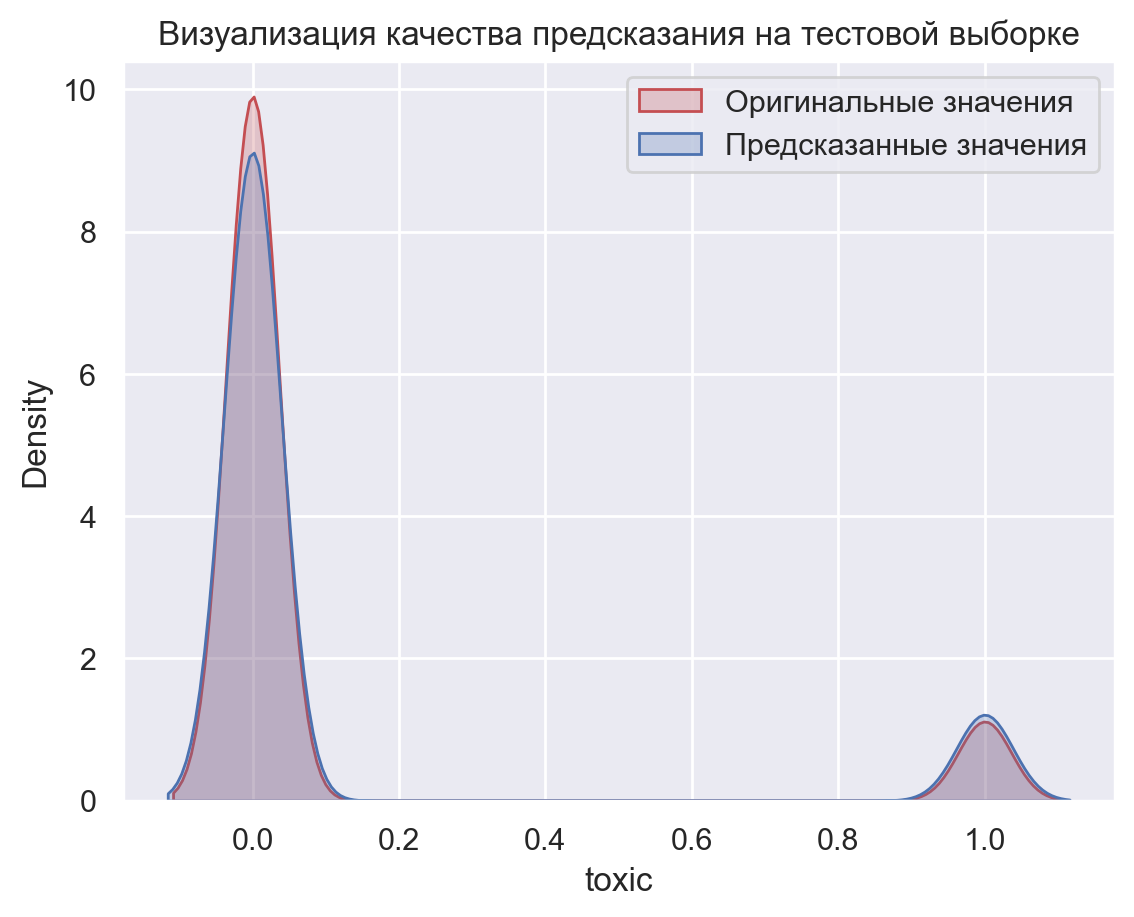

In [140]:
sns.set(style="darkgrid")
fig = sns.kdeplot(target_test, shade=True, color="r", label='Оригинальные значения')
fig = sns.kdeplot(pred, shade=True, color="b", label='Предсказанные значения')
plt.legend()
plt.title('Визуализация качества предсказания на тестовой выборке')
plt.show()

## Выводы

Для интернет-магазина "Викишоп" разработали модель классификации комментариев на токсичные и позитивные **с качеством F1 на тестовой выборке равной 0.7622**.


**Была выполнена следующая работа**

- Предобработка текста: Очистили текст от стоп-слов, лишних знаков, лемматизировали и применили TF-idf
- Обучение моделей: использовали 5 моделей классификации и проверяли их качество с помощью кросс-валидации на метрике F1
- Лучший результат дала  модель LogisticRegression. Проверили ее работу на тестовой выборке